In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing.image import ImageDataGenerator

from models.cnn import get_model
from utils.dataset import get_class_paths

import os

In [11]:
model_path = os.path.join("../trained_models", "mini_XCEPTION.116-0.99.h5")
input_shape = (224, 224, 3)
num_classes = 4
model_parameters = {
    "input_shape": input_shape,
    "num_classes": num_classes
}

model = get_model("mini_XCEPTION", model_parameters)
model.load_weights(model_path)

In [26]:
log_path = os.path.join("../trained_models", "mini_XCEPTION.log")
history = pd.read_csv(log_path)
history.head()

,epoch,accuracy,loss,lr,precision,recall,val_accuracy,val_loss,val_precision,val_recall
0,0,0.668401,0.917056,0.001,0.729484,0.596468,0.240713,2.188395,0.240713,0.240713
1,1,0.751859,0.719217,0.001,0.796237,0.692193,0.216939,2.815627,0.173489,0.132244
2,2,0.807435,0.608603,0.001,0.834877,0.770632,0.267459,4.232914,0.276461,0.260030
3,3,0.799071,0.591975,0.001,0.820309,0.768773,0.561664,1.828460,0.582946,0.558692
4,4,0.837732,0.507808,0.001,0.857563,0.813569,0.618128,1.144870,0.642055,0.594354


In [ ]:
# Get training and validation metrics from history
metrics = ['accuracy', 'loss', 'precision', 'recall']
tr_metrics = history[metrics].copy()
val_metrics = history[[f"val_{m}" for m in metrics]].copy()
val_metrics.columns = metrics

In [33]:
# Find best epochs and values
best_epochs = {}
best_values = {}

for m in metrics:
    if m == 'loss':
        idx = np.argmin(val_metrics[m])
    else:
        idx = np.argmax(val_metrics[m])
    best_epochs[m] = idx + 1
    best_values[m] = val_metrics[m][idx]

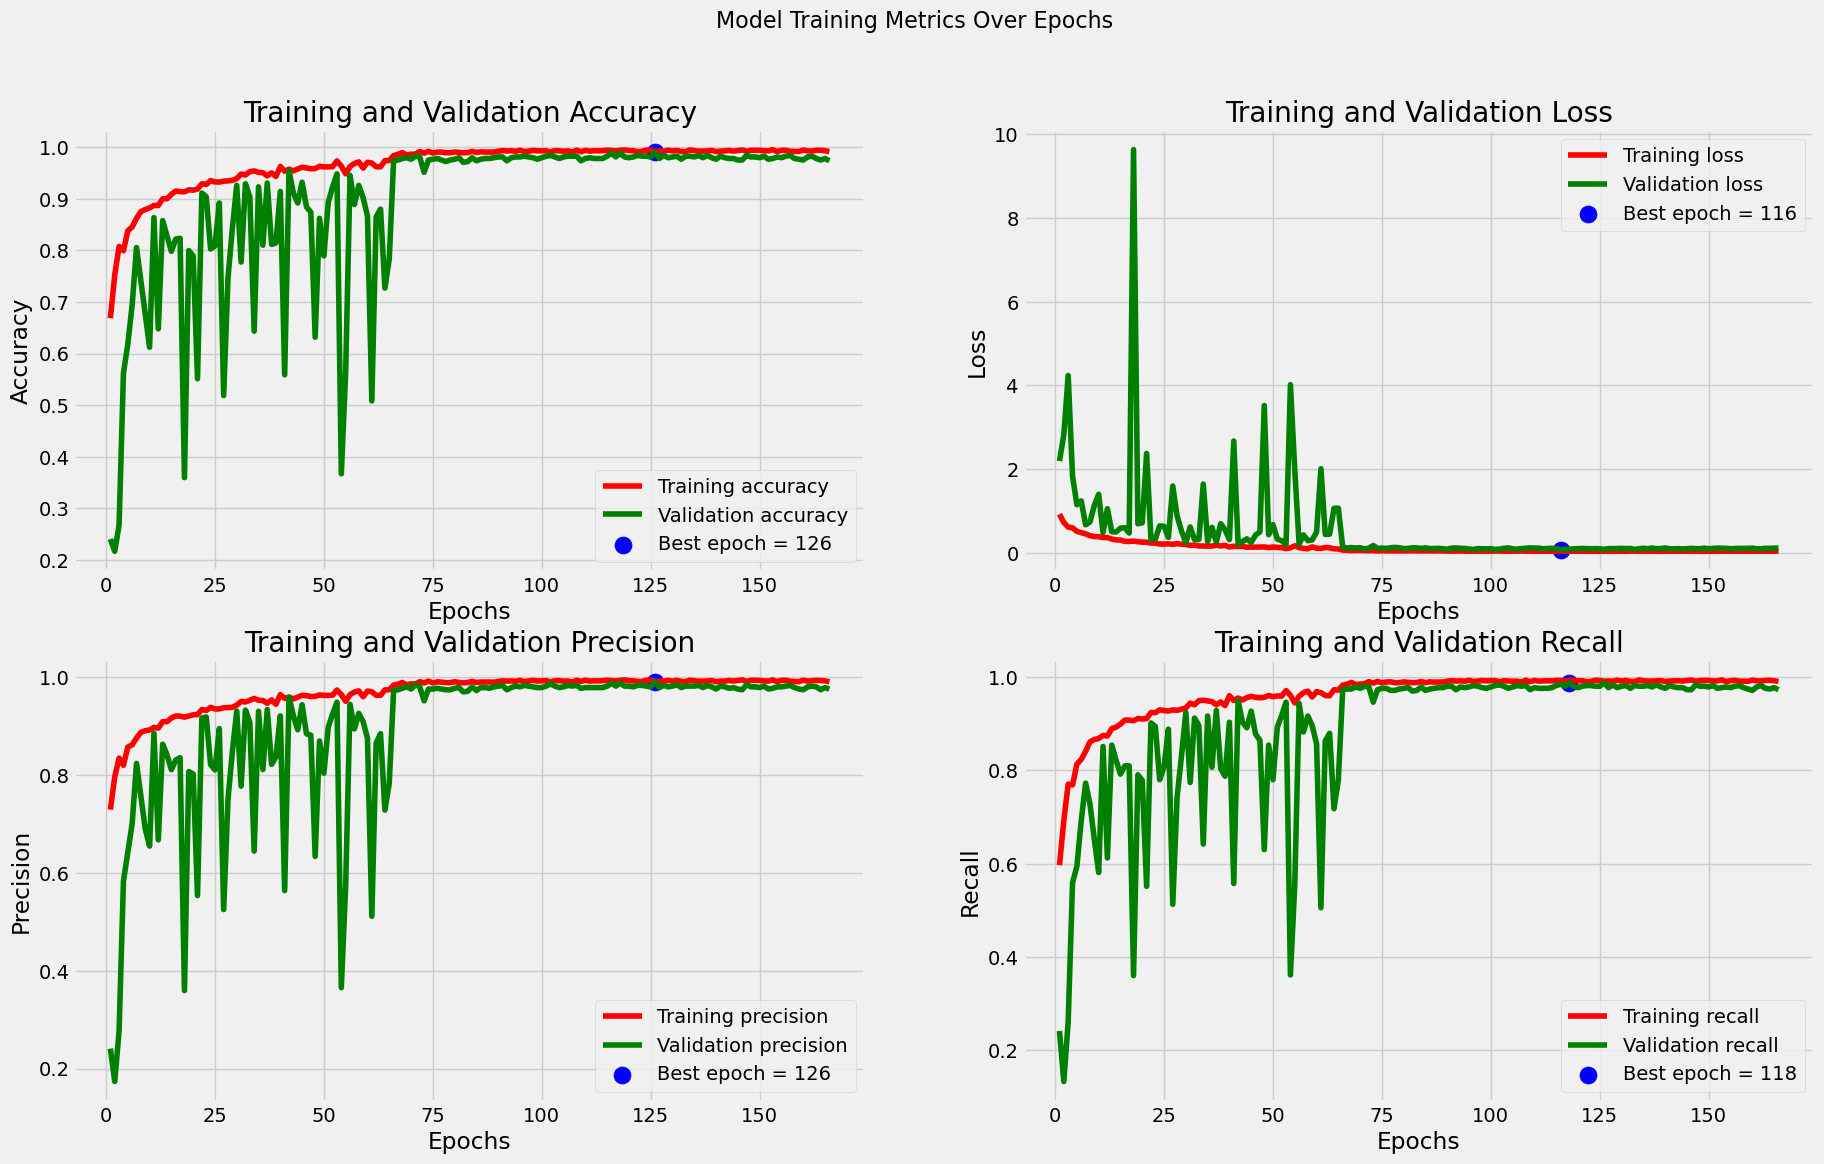

In [34]:
# Plot metrics
# Plot metrics
plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    epochs = range(1, len(tr_metrics[metric]) + 1)

    plt.plot(epochs, tr_metrics[metric], 'r', label=f'Training {metric}')
    plt.plot(epochs, val_metrics[metric], 'g', label=f'Validation {metric}')
    plt.scatter(best_epochs[metric], best_values[metric], s=150, c='blue',
                label=f'Best epoch = {best_epochs[metric] }')

    plt.title(f'Training and Validation {metric.title()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.title())
    plt. legend()
    plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [40]:
image_generator = ImageDataGenerator(
    rescale=1/255,
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=.1,
    horizontal_flip=True
)
test_generator = ImageDataGenerator(rescale=1/255)
validation_split = 0.2
batch_size = 32
image_size = (224,224)

# loading dataset
df = get_class_paths()
train_df, test_df = train_test_split(df, test_size=validation_split, stratify=df['Class'])
valid_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df['Class'])

train_generator = image_generator.flow_from_dataframe(train_df, x_col='Class Path', y_col='Class', batch_size=batch_size, target_size=image_size)
valid_generator = image_generator.flow_from_dataframe(valid_df, x_col='Class Path', y_col='Class', batch_size=batch_size, target_size=image_size)
test_generator = test_generator.flow_from_dataframe(test_df,  x_col='Class Path', y_col='Class', batch_size=16, target_size=image_size, shuffle=False)


Found 5380 validated image filenames belonging to 4 classes.
Found 673 validated image filenames belonging to 4 classes.
Found 673 validated image filenames belonging to 4 classes.


In [41]:
train_score = model.evaluate(train_generator, verbose=1)
valid_score = model.evaluate(valid_generator, verbose=1)
test_score = model.evaluate(test_generator, verbose=1)

print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print(f"Train Loss: {train_score[0]:.4f}")
print(f"\n\nValidation Accuracy: {valid_score[1]*100:.2f}%")
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"\n\nTest Accuracy: {test_score[1]*100:.2f}%")
print(f"Test Loss: {test_score[0]:.4f}")

43/43 [==============================] - 2s 41ms/step - loss: 0.0949 - accuracy: 0.9733 - precision: 0.9747 - recall: 0.9733
Train Accuracy: 99.37%
Train Loss: 0.0342


Validation Accuracy: 99.11%
Validation Loss: 0.0388


Test Accuracy: 97.33%
Test Loss: 0.0949


43/43 [==============================] - 2s 43ms/step


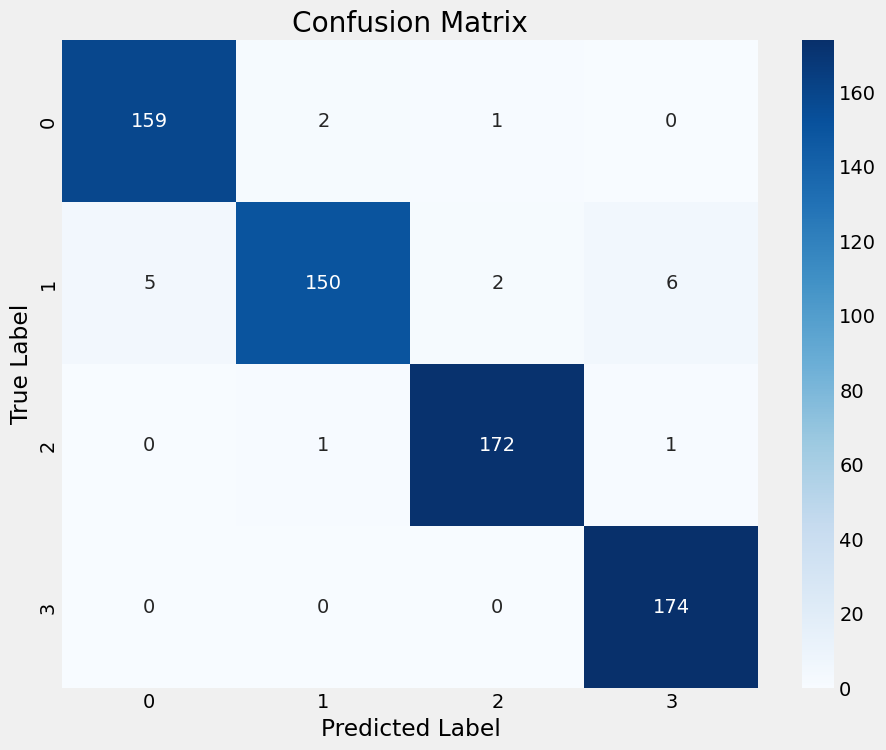

In [43]:
preds = model.predict(test_generator)
y_pred = np.argmax(preds, axis=1)

class_dict = {
    0: 'glioma',
    1: 'meningioma',
    2: 'no_tumor',
    3: 'pituitary'
}

# Then create and display the confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()